In [1]:
!pip install -Uq transformers accelerate einops bitsandbytes chromadb langchain pymupdf pytz gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import json
import gradio

import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

import torch
from torch import cuda, bfloat16
from langchain.text_splitter import RecursiveCharacterTextSplitter

import chromadb
from chromadb.utils import embedding_functions

from datetime import datetime
import json
import fitz
import pytz

import os

# if using Google Colab uncomment the following lines
from google.colab import drive

drive.mount("/content/drive")
os.chdir(r"/content/drive/My Drive/AAI courses/TA Chatbot") # Change to desired dir

Mounted at /content/drive


Set up the database

In [3]:
CHROMA_DATA_PATH = "chromadb_database"


def fetch_database(hf_auth=None, ef_name="sentence-transformers/all-mpnet-base-v2"):
    if hf_auth:
        ef = embedding_functions.HuggingFaceEmbeddingFunction(
            api_key=hf_auth, model_name=ef_name
        )
    else:
        ef = (
            embedding_functions.DefaultEmbeddingFunction()
        )  # use the default all-MiniLM-L6-v2

    client = chromadb.PersistentClient(path=CHROMA_DATA_PATH)
    collection = client.get_or_create_collection(
        name="course_material", embedding_function=ef
    )
    return client, collection


# with open("creds.txt", "r") as file: # load your hugging face token
#     hf_auth = json.load(file)["hf_token"]

client, collection = fetch_database()

In [4]:
def load_material(collection=collection, chunk_size=250, chunk_overlap=20):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )
    if collection.count():  # if the store is already built, abort
        return
    ids = 0
    data_path = "data"

    for file in os.listdir(data_path):
        docs = []
        if file.startswith(
            "module"
        ):  # excpecting data poinoning folders to have the name module#
            week_num = file[6]
        else:
            week_num = 0  # means available at all time

        try:
            curr_file = fitz.open(os.path.join(data_path, file))
            for i in range(len(curr_file)):
                if curr_file[i].get_text():
                    for doc in text_splitter.split_text(curr_file[i].get_text()):
                        docs.append(doc)
            idx = list(f"{i}" for i in range(ids, ids + len(docs)))
            ids += len(docs)
            meta_data = [{"week": f"{week_num}"}] * len(idx)

            collection.add(documents=docs, metadatas=meta_data, ids=idx)

        except Exception as e:
            print("Could not process ", file, "\nError: ", e, sep="")


load_material()

In [5]:
# set the end date for each week
dates = [
    datetime.strptime("2024-04-09", "%Y-%m-%d").date(),  # beginning of week 1
    datetime.strptime("2024-04-10", "%Y-%m-%d").date(),  # end of week 1
    datetime.strptime("2024-04-11", "%Y-%m-%d").date(),  # end of week 2
    datetime.strptime("2024-04-12", "%Y-%m-%d").date(),  # end of week 3...
    datetime.strptime("2024-04-13", "%Y-%m-%d").date(),
    datetime.strptime("2024-04-14", "%Y-%m-%d").date(),
    datetime.strptime("2024-04-15", "%Y-%m-%d").date(),
]


def query_db(
    query, metadata_filters, n_results=1
):  # only fetch the most similar document
    results = collection.query(
        query_texts=query,
        n_results=n_results,
        where=metadata_filters,
    )
    return results


tz = pytz.timezone("America/Los_Angeles")


def fetch_docs(query, n_docs=3, tz=tz):
    now = datetime.now(tz).date()

    for i in range(len(dates)):
        if now <= dates[i]:
            metadata_filters = {"week": {"$in": ["0", str(i + 1)]}}

            return "\n\n".join(
                query_db(query, metadata_filters, n_docs)["documents"][0]
            )

Load the LLM

In [6]:
def load_model(hf_auth, model_id, temperature=0.001):
    # Determine the device (GPU if available, else CPU)
    device = f"cuda:{cuda.current_device()}" if cuda.is_available() else "cpu"

    # Configure quantization settings for loading the model with less GPU memory usage
    bnb_config = transformers.BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=bfloat16,
    )

    # Load the configuration for the pre-trained model
    model_config = transformers.AutoConfig.from_pretrained(model_id, token=hf_auth)

    tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_auth)

    # Load the model for causal language modeling
    model = transformers.AutoModelForCausalLM.from_pretrained(
        model_id,
        trust_remote_code=True,
        config=model_config,
        quantization_config=bnb_config,
        device_map="auto",
        token=hf_auth,
    )

    model.config.use_cache = False

    # Set the model in evaluation mode for inference
    model.eval()

    pipe = pipeline(
        task="text-generation",
        model=model,
        tokenizer=tokenizer,
        temperature=temperature,
        # top_k=40,
        eos_token_id=tokenizer.eos_token_id,
        # repetition_penalty=1.5,
        return_full_text=False,
        # do_sample=True,
    )

    # Print device information where the model is loaded
    print(f"Model loaded on {device}")

    return pipe


with open("creds.txt", "r") as file:
    hf_auth = json.load(file)["hf_token"]

pipe = load_model(hf_auth, "meta-llama/Llama-2-13b-chat-hf")

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

Model loaded on cuda:0


We will use the following prompt template:

```
<s>[INST] <<SYS>>
{{ system_prompt }}
<</SYS>>

{{ user_msg_1 }} [/INST] {{ model_answer_1 }} </s><s>[INST] {{ user_msg_2 }} [/INST] {{ model_answer_2 }} </s><s>[INST] {{ user_msg_3 }} [/INST]
```

We will pass the context in the following structure:

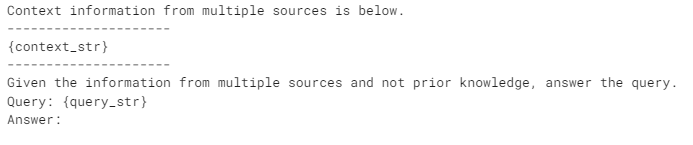

In [7]:
SYS_PROMPT = """You are an expert teacher assistant for a course called ADS 500B. You answer questions relating to software engineering, data science, and AI.\
You are honest and helpful. You answer succinctly and professionally. You do not make up facts. Use the Context provided to answer the question. If the context says "I cannot share upcoming assignment solutions." Say that. Don't answer the question.\
If you're asked something you do not know the answer to, say you do not know. Do not make up facts. Be brief and to the point.\
"""

TEMPLATE = "<s>[INST] <<SYS>>\n{sys_prompt}\n<</SYS>>"

_SYS_PROMPT = TEMPLATE.format(sys_prompt=SYS_PROMPT)


def build_prompt(query_w_context: str, hist_len: int = 3):
    if not len(history):  # if first query
        return _SYS_PROMPT + f"\n\n{query_w_context} [/INST] "

    prompt = _SYS_PROMPT + "\n\n"

    for i in range(len(history)):
        if i == 0:
            prompt += f"{history[i]} [/INST] "
            continue

        if i % 2 == 0:
            prompt += f"<s>[INST]{history[i]} [/INST] "

        else:
            prompt += f"{history[i]} </s>"

    return prompt + f"<s>[INST]{query_w_context} [/INST] "


def query_model(query: str, hist_len: int = 3):
    global history

    context = fetch_docs(query=query, n_docs=1)

    query_w_context = f"""Context information from multiple sources is below.
---------------------
{context}
---------------------
Given the information from multiple sources and prior knowledge, answer the query.
Query: {query}
Answer: """

    prompt = build_prompt(query_w_context, hist_len)
    response = pipe(prompt, max_new_tokens=1024)[0]["generated_text"]

    history.append(query)
    history.append(response)

    if len(history) > hist_len:
        history = history[
            -(hist_len * 2) :
        ]  # only keep hist_len interaction pair history.
    return response

In [8]:
global history
history = []
hist_len = 2


def chatbot_interface(query, gradio_hist):
    gradio_hist = None
    result = query_model(query)
    return result


interface = gradio.ChatInterface(
    fn=chatbot_interface,
    title="<div style='display: flex; align-items: center;'><img src='https://logos-download.com/wp-content/uploads/2021/01/University_of_San_Diego_Logo_full-1536x1536.png' alt='Your Image' style='margin-right: 10px; max-height: 100px'><h1 style='flex:1; margin-right: 100px; text-align: center;'>Virtual Teaching Assistant for ADS 500B</h1></div>",
    examples=[
        "What do data scientists do?",
        "How to save changes and exit the file in the vi text editor?",
        "What programming languages are needed for this course?",
    ],
    description="RAG system with Llama 2 and ChromaDB with metadata filtering to hide/reveal homework questions based on the due date.",
)

In [9]:
interface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://5a1d9c69272da0958d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://5a1d9c69272da0958d.gradio.live
